# CMSE 381 Final Project Template

**INSTRUCTIONS**: This is a template to help organize your project.  All projects should include the 5 major sections below (you do not need to use this template file).  If you use this file, complete your work below and remove content in parentheses. Also, remove this current cell.  

#### CMSE 381 Final Project
###  Group members: Sukaina Alkhalidy, Sherry
###  Section_001
####  The Freiwald Tsao Face View AM dataset

# Neural Decoding of Faces and Head Orientation

## Background and Motivation

_(Provide context for the problem.  **Clearly state the question(s) you set
out to answer.**)_

##### Have you ever wondered how the brain figures out who we're looking at—just from a glance at a face? That’s exactly what this project explores. Scientists have discovered that a specific part of the brain, the anterior medial (AM) face patch, lights up when we see faces. The dataset we’re working with records activity from this region while a monkey views different faces from various angles.

##### Our goal is to decode what the monkey was seeing just by looking at its brain activity. This process is known as neural decoding, and it's a fascinating way to connect neuroscience with machine learning. By analyzing patterns in neuron firing, we want to figure out if we can tell who the face was and which way it was facing.But we’re not stopping there. We also want to see which machine learning models do the best job at making these predictions. Can simpler models like logistic regression handle this? Or do we need more complex algorithms like random forests or support vector machines?

## Questions:

### question 1 :Can we classify the face identity seen by the subject using neuron activity?
### question 2: Can we determine the head orientation based on neural responses?
### Question 3: How accurately can different machine learning models decode facial perception?

## Methodology
_(How did you go about answering your question(s)? You should wrote some code here to demonstrate what the data is like and how in principle your method works. You can leave the variations of the related to specific results to the results section.)_

# importing everything 

In [1]:

pip install "numpy<2" matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
# Enable inline plotting for Jupyter Notebook
%matplotlib inline


### First, we load the dataset from the extracted folder and inspect its structure.

In [3]:

# Define the dataset folder path
folder_path = "Freiwald_Tsao_faceviews_AM_data_csv"

# List all CSV files
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

# Load one sample file to inspect the structure
sample_file = os.path.join(folder_path, csv_files[0])  # First CSV file
df = pd.read_csv(sample_file)

# Display info
print("Dataset Loaded:", sample_file)
print(df.head())  # Show first few rows
print(df.info())  # Column details



Dataset Loaded: Freiwald_Tsao_faceviews_AM_data_csv/raster_data_bert_am_site070.csv
  site_info.monkey site_info.region  labels.stimID  labels.person  \
0             bert               am              1              1   
1             bert               am              1              1   
2             bert               am              1              1   
3             bert               am              1              1   
4             bert               am              1              1   

  labels.orientation labels.orient_person_combo  time.1_2  time.2_3  time.3_4  \
0              front                    front 1         0         0         0   
1              front                    front 1         0         0         0   
2              front                    front 1         0         0         0   
3              front                    front 1         0         0         0   
4              front                    front 1         0         0         0   

   time.4_5  .

### Handling Missing Data
## The dataset has no explicit missing values, but we handle any potential issues.

In [4]:
df = df.replace('?', np.nan)  # Convert '?' to NaN if applicable
df = df.dropna()  # Drop rows with missing values
print("Dataset shape after cleaning:", df.shape)


Dataset shape after cleaning: (1600, 806)


In [5]:
print(df.dtypes)  # Check column data types


site_info.monkey      object
site_info.region      object
labels.stimID          int64
labels.person          int64
labels.orientation    object
                       ...  
time.796_797           int64
time.797_798           int64
time.798_799           int64
time.799_800           int64
time.800_801           int64
Length: 806, dtype: object


In [23]:
# Peek at the data
print("First few rows:")
print(df.head())

# Check what types of data we’re working with
print("Column types:")
print(df.dtypes.value_counts())

# See what categories we're predicting
print("Face identity distribution:")
print(df['labels.person'].value_counts().sort_index())

First few rows:
   labels.stimID  labels.person  time.1_2  time.2_3  time.3_4  time.4_5  \
0              1              1         0         0         0         0   
1              1              1         0         0         0         0   
2              1              1         0         0         0         0   
3              1              1         0         0         0         0   
4              1              1         0         0         0         0   

   time.5_6  time.6_7  time.7_8  time.8_9  ...  \
0         0         0         0         0  ...   
1         0         0         0         0  ...   
2         0         0         0         0  ...   
3         0         0         0         0  ...   
4         0         0         0         0  ...   

   labels.orient_person_combo_190  labels.orient_person_combo_191  \
0                           False                           False   
1                           False                           False   
2                        

#plot of the neural activity for one trial:

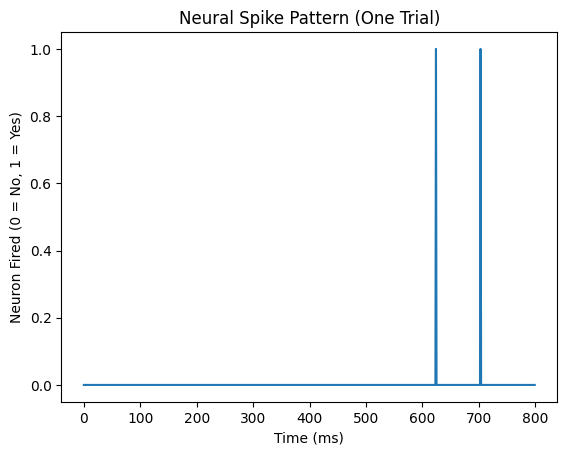

In [24]:
import matplotlib.pyplot as plt

spike_columns = [col for col in df.columns if 'time.' in col]
plt.plot(df.loc[0, spike_columns].values)
plt.title("Neural Spike Pattern (One Trial)")
plt.xlabel("Time (ms)")
plt.ylabel("Neuron Fired (0 = No, 1 = Yes)")
plt.show()


### Models for classification 
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

### question 1 :Can we classify the face identity seen by the subject using neuron activity?

## Encode Categorical Variables

In [5]:
# Encode categorical columns
label_encoder = LabelEncoder()

categorical_cols = ['site_info.monkey', 'site_info.region', 
                    'labels.orientation', 'labels.orient_person_combo']

for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])

print("After encoding:")
print(df[categorical_cols].head())


After encoding:
   site_info.monkey  site_info.region  labels.orientation  \
0                 0                 0                   2   
1                 0                 0                   2   
2                 0                 0                   2   
3                 0                 0                   2   
4                 0                 0                   2   

   labels.orient_person_combo  
0                          50  
1                          50  
2                          50  
3                          50  
4                          50  


## Set up Features and Labels
## Train a Random Forest Classifier
#### We'll use a Random Forest to classify which face identity (labels.person) the subject saw based on the neural activity.

In [6]:
# Define features (X) and labels (y)
X = df.drop(columns=['labels.person', 'labels.stimID'])  # Features
y = df['labels.person']  # Face identity (target)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate model performance
print("\n🌲 Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\n🌲 Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))



X_train shape: (1280, 804)
y_train shape: (1280,)

🌲 Random Forest Accuracy: 0.7031
              precision    recall  f1-score   support

           1       0.88      0.78      0.82         9
           2       0.58      0.78      0.67         9
           3       0.69      0.60      0.64        15
           4       0.56      0.82      0.67        11
           5       1.00      0.55      0.71        11
           6       0.81      0.81      0.81        16
           7       0.75      0.82      0.78        11
           8       0.80      0.57      0.67        14
           9       0.78      0.82      0.80        17
          10       0.62      0.45      0.53        11
          11       0.75      1.00      0.86         9
          12       0.79      0.92      0.85        12
          13       0.72      0.76      0.74        17
          14       0.83      0.56      0.67         9
          15       0.60      0.80      0.69        15
          16       0.89      0.53      0.67        

#### Training the Random Forest model):

In [7]:
# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluate
print("\n🌲 Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print(classification_report(y_test, y_pred_rf))



🌲 Random Forest Accuracy: 0.7031
              precision    recall  f1-score   support

           1       0.88      0.78      0.82         9
           2       0.58      0.78      0.67         9
           3       0.69      0.60      0.64        15
           4       0.56      0.82      0.67        11
           5       1.00      0.55      0.71        11
           6       0.81      0.81      0.81        16
           7       0.75      0.82      0.78        11
           8       0.80      0.57      0.67        14
           9       0.78      0.82      0.80        17
          10       0.62      0.45      0.53        11
          11       0.75      1.00      0.86         9
          12       0.79      0.92      0.85        12
          13       0.72      0.76      0.74        17
          14       0.83      0.56      0.67         9
          15       0.60      0.80      0.69        15
          16       0.89      0.53      0.67        15
          17       0.73      0.92      0.81    

# Import visualization tools

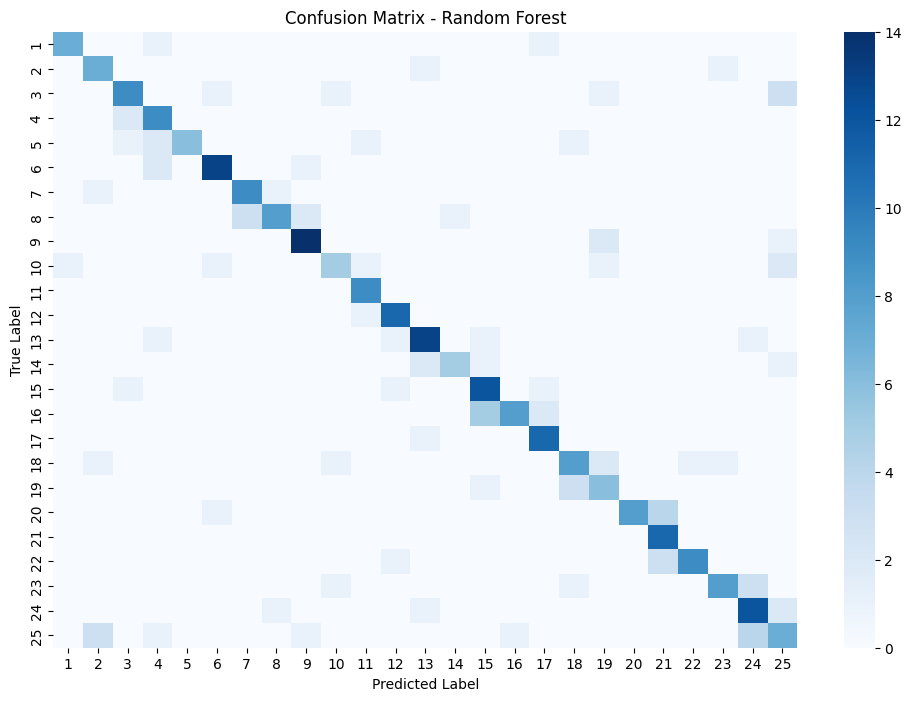

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Plot it
plt.figure(figsize=(12, 8))
sns.heatmap(cm, cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Random Forest")
plt.show()


#  7A. Train & Evaluate Support Vector Classifier (SVC)

In [9]:
# Train SVC
svc_model = SVC(kernel='linear')
svc_model.fit(X_train, y_train)

# Predict
y_pred_svc = svc_model.predict(X_test)

# Evaluate
print("\n🔷 SVC Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print(classification_report(y_test, y_pred_svc))



🔷 SVC Accuracy: 0.0813
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         9
           2       0.00      0.00      0.00         9
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00        11
           5       0.00      0.00      0.00        11
           6       0.00      0.00      0.00        16
           7       0.08      0.18      0.11        11
           8       0.03      0.14      0.04        14
           9       0.54      0.41      0.47        17
          10       0.50      0.09      0.15        11
          11       0.20      0.22      0.21         9
          12       0.00      0.00      0.00        12
          13       0.00      0.00      0.00        17
          14       0.00      0.00      0.00         9
          15       0.06      0.20      0.09        15
          16       0.25      0.07      0.11        15
          17       0.06      0.42      0.11        12
   

/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/miniconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 7B. Train & Evaluate K-Nearest Neighbors (KNN)

In [10]:
# Train KNN
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)

# Predict
y_pred_knn = knn_model.predict(X_test)

# Evaluate
print("\n🔸 KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))
print(classification_report(y_test, y_pred_knn))



🔸 KNN Accuracy: 0.5781
              precision    recall  f1-score   support

           1       0.73      0.89      0.80         9
           2       0.32      0.89      0.47         9
           3       0.56      0.67      0.61        15
           4       0.15      0.18      0.17        11
           5       0.50      0.55      0.52        11
           6       0.67      0.88      0.76        16
           7       0.64      0.64      0.64        11
           8       1.00      0.29      0.44        14
           9       0.61      0.82      0.70        17
          10       0.86      0.55      0.67        11
          11       0.46      0.67      0.55         9
          12       0.47      0.58      0.52        12
          13       0.78      0.41      0.54        17
          14       0.75      0.33      0.46         9
          15       0.70      0.93      0.80        15
          16       1.00      0.53      0.70        15
          17       0.42      0.83      0.56        12
   

In [11]:
# Accuracy summary
print("\n📊 Model Comparison:")
print("Random Forest Accuracy:", round(accuracy_score(y_test, y_pred_rf), 4))
print("SVC Accuracy:", round(accuracy_score(y_test, y_pred_svc), 4))
print("KNN Accuracy:", round(accuracy_score(y_test, y_pred_knn), 4))



📊 Model Comparison:
Random Forest Accuracy: 0.7031
SVC Accuracy: 0.0813
KNN Accuracy: 0.5781


####  Exploratory Data Analysis (EDA) Now, let's analyze the data to understand its distribution.
### Check the Distribution of Labels (Face Identity & Orientation)

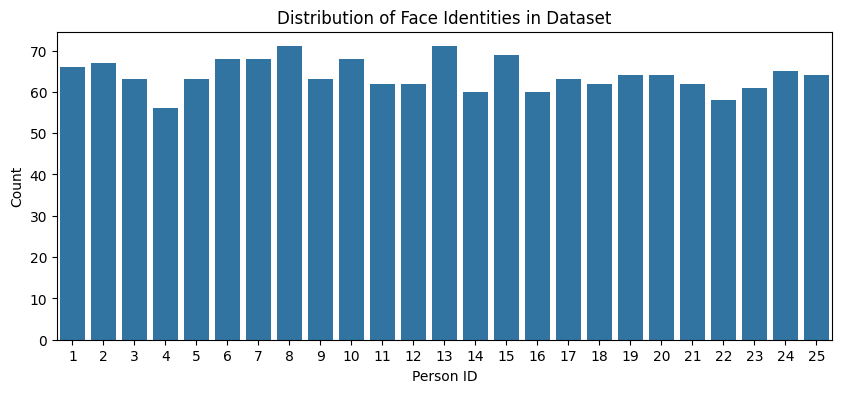

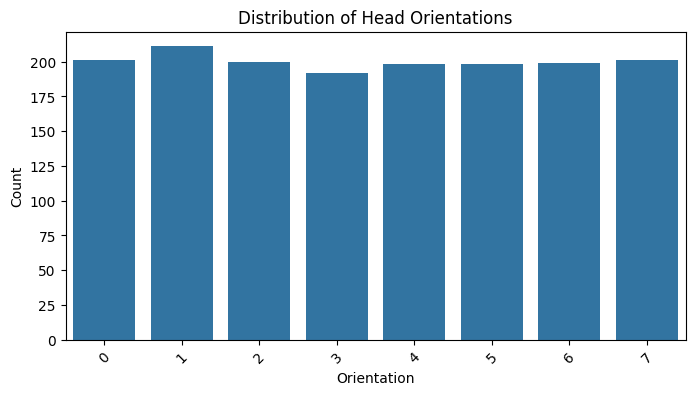

In [12]:

plt.figure(figsize=(10, 4))

# Count of different individuals in the dataset
sns.countplot(x=df["labels.person"])
plt.title("Distribution of Face Identities in Dataset")
plt.xlabel("Person ID")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8, 4))

# Count of different orientations
sns.countplot(x=df["labels.orientation"])
plt.title("Distribution of Head Orientations")
plt.xlabel("Orientation")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [13]:
df = pd.get_dummies(df, columns=['site_info.monkey', 'site_info.region', 'labels.orientation', 'labels.orient_person_combo'])

# Drop non-feature columns (target variable and any metadata not needed)
X = df.drop(columns=['labels.person', 'labels.stimID'])
y = df['labels.person']  # Target variable

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [14]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Evaluate performance
print("Random Forest Classifier Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Classifier Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.0

In [15]:
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)

# Evaluate performance
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.996875
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9
           3       1.00      1.00      1.00        15
           4       1.00      1.00      1.00        11
           5       1.00      1.00      1.00        11
           6       1.00      1.00      1.00        16
           7       1.00      1.00      1.00        11
           8       1.00      1.00      1.00        14
           9       1.00      1.00      1.00        17
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00        17
          14       1.00      1.00      1.00         9
          15       1.00      1.00      1.00        15
          16       1.00      1.00      1.00        15
          17       1.00      1.00      1.00        12
    

##  k-Fold Cross-Validation (Random Forest)

In [18]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation on the entire scaled dataset
cv_scores_rf = cross_val_score(rf_model, X_scaled, y, cv=5)

print(" Random Forest CV Scores:", cv_scores_rf)
print("Average CV Accuracy (Random Forest):", round(np.mean(cv_scores_rf), 4))


 Random Forest CV Scores: [0.246875 0.3375   0.4875   0.34375  0.2875  ]
Average CV Accuracy (Random Forest): 0.3406


# Cross-Validation for SVC and KNN

In [20]:
cv_scores_svc = cross_val_score(svc_model, X_scaled, y, cv=5)
cv_scores_knn = cross_val_score(knn_model, X_scaled, y, cv=5)

print("🔷 SVC CV Accuracy:", round(np.mean(cv_scores_svc), 4))
print("🔸 KNN CV Accuracy:", round(np.mean(cv_scores_knn), 4))


🔷 SVC CV Accuracy: 0.075
🔸 KNN CV Accuracy: 0.1625


### Data
_(Describe the data you are using. What variables are you using? What they mean? Why did you choose them?)_

##### The dataset we used comes from a neuroscience experiment where a monkey passively viewed images of human faces. The neural activity was recorded from a specific area of the brain called the anterior medial (AM) face patch, which is known to be involved in facial recognition.

##### Each row in the dataset represents a single trial, meaning one face image shown to the monkey. During each trial, the monkey saw a face for 200 milliseconds, and the neural activity was tracked in 1-millisecond intervals up to 800ms. This gives us a detailed view of how the brain responds over time.

In [10]:
# you may need some code here to adjust the format or organization of your data so that
# they can be used for the model


## What’s in the data?

##### labels.person – This is the identity of the person in the face image (used as our classification label).
##### labels.orientation – This tells us the direction the face was looking (used later for regression).
##### time.1_2 to time.800_801 – These columns represent the neural spikes. A 1 means the neuron fired at that millisecond, and a 0 means it didn’t.
##### Other columns – There are also some metadata columns like which monkey the data came from and which region of the brain was recorded.These were useful for exploration but not critical for modeling.

### Models for classification _(if applicable)_
_(What models will you be using for classification? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [12]:
# you may add some code here to show how the model works in principle

### Models for regression _(if applicable)_
_(What models will you be using for regression? Why did you choose to use them? What questions would you answer with them? How would you evaluate if each model? What cross-validation method did you use?)_

In [13]:
# you may add some code here to show how the model works in principle

### Other methods used _(if applicable)_

_(If this is a preprocessing step to prepare your data for regression or classification models, you should put this subsection before your explanation for the regression or classification models.)_

_(What method did you use otherwise? Why did you choose to use them? What questions would you answer with them? How would you evaluate the results? What cross-validation method did you use when applicable?)_

In [14]:
# you may add some code here to show how the method works in principle

# you may add some code here to show how the model works in principle

## Results

_(What did you find when you carried out your methods? Some of your code related to
presenting results/figures/data may be replicated from the methods section or may only be present in
this section. All of the plots that you plan on using for your presentation should be present in this
section)_

### classification results
_(What are you trying to do here?)_

In [15]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [16]:
# how did you do it (etc. etc.)

### regression results
_(What are you trying to do here?)_

In [17]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [18]:
# how did you do it (etc. etc.)

### other results
_(What are you trying to do here?)_

In [19]:
# how did you do it

_(How do you interpret what you see?)_

_(What are you doing next?)_

In [20]:
# how did you do it (etc. etc.)

## Discussion and Conclusion

_(What did you learn from your results? What obstacles did you run into? What would you do differently next time? Clearly provide quantitative answers to your question(s)?  At least one of your questions should be answered with numbers.  That is, it is not sufficient to answer "yes" or "no", but rather to say something quantitative such as variable 1 increased roughly 10% for every 1 year increase in variable 2.)_

### discussion on the classification results

### discussion on the other results

### conclusion and future steps

## Author contribution

_(Please describe the contribution of each member of group)._

## References

_(List the source(s) for any data and/or literature cited in your project.  Ideally, this should be formatted using a formal citation format (MLA or APA or other, your choice!).   Multiple free online citation generators are available such as <a href="http://www.easybib.com/style">http://www.easybib.com/style</a>. **Important:** if you use **any** code that you find on the internet for your project you **must** cite it or you risk losing most/all of the points for you project.)_

### Freiwald, W. A., & Tsao, D. Y. (2010). Functional compartmentalization and viewpoint generalization within the macaque face-processing system. Science, 330(6005), 845-851.

### Meyers, E. M., Borzello, M., Freiwald, W. A., & Tsao, D. (2015). Intelligent information loss: The coding of facial identity, head pose, and non-face information in the macaque face patch system. Journal of Neuroscience, 35(18)

### “Seaborn.Countplot#.” Seaborn.Countplot - Seaborn 0.13.2 Documentation, seaborn.pydata.org/generated/seaborn.countplot.html. Accessed 5 Mar. 2025. 